# My onw implementation of SLIC

In [79]:
import numpy as np
from PIL import Image
import math

### Some functions to change colorspace

In [80]:
def lab2rgb_one_pixel(lab):
    num = 0
    Lab = [0, 0, 0]

    for value in lab:
        Lab[num] = float(value)
        num = num + 1

    xyz = [0, 0, 0]

    xyz[1] = (Lab[0] + 16) / 116
    xyz[0] = Lab[1] / 500 + xyz[1]
    xyz[2] = xyz[1] - float(Lab[2]) / 200

    for value in range(len(xyz)):
        if ( math.pow( xyz[value] , 3 ) > 0.008856 ):
            xyz[value] = math.pow( xyz[value] , 3 )
        else:
            xyz[value] = ( xyz[value] - 16 / 116 ) / 7.787

    xyz[0] = 95.047 * xyz[0]        # ref_X =  95.047   Observer= 2°, Illuminant= D65
    xyz[1] = 100.000 * xyz[1]       # ref_Y = 100.000
    xyz[2] = 108.883 * xyz[2]       # ref_Z = 108.883

    for value in range(len(xyz)):
        xyz[value] = xyz[value] / 100

    RGB = [0, 0, 0]    

    RGB[0] = xyz[0] * 3.24063 + xyz[1] * -1.53721 + xyz[2] * -0.498629
    RGB[1] = xyz[0] * -0.968931 + xyz[1] * 1.87576 + xyz[2] * 0.0415175
    RGB[2] = xyz[0] * 0.0557101 + xyz[1] * -0.204021 + xyz[2] * 1.0570

    for value in range(len(RGB)):
        if ( RGB[value] > 0.0031308 ):
            RGB[value] = 1.055 * math.pow( RGB[value]  , ( 1 / 2.4 ) ) - 0.055
        else:
            RGB[value] = 12.92 * RGB[value]
        RGB[value] = round( RGB[value] * 255, 4)
        if ( RGB[value] < 0 ):
            RGB[value] = 0
        elif ( RGB[value] > 255 ):
            RGB[value] = 255

    return RGB[0], RGB[1], RGB[2]

def rgb2lab_one_pixel(rgb):
    r = rgb[0] / 255.0  # rgb range: 0 ~ 1
    g = rgb[1] / 255.0
    b = rgb[2] / 255.0
    # gamma 2.2
    if r > 0.04045:
        r = pow((r + 0.055) / 1.055, 2.4)
    else:
        r = r / 12.92
    if g > 0.04045:
        g = pow((g + 0.055) / 1.055, 2.4)
    else:
        g = g / 12.92
    if b > 0.04045:
        b = pow((b + 0.055) / 1.055, 2.4)
    else:
        b = b / 12.92
    # sRGB
    X = r * 0.436052025 + g * 0.385081593 + b * 0.143087414
    Y = r * 0.222491598 + g * 0.716886060 + b * 0.060621486
    Z = r * 0.013929122 + g * 0.097097002 + b * 0.714185470
    # XYZ range: 0~100
    X = X * 100.000
    Y = Y * 100.000
    Z = Z * 100.000
    # Reference White Point
    ref_X = 96.4221
    ref_Y = 100.000
    ref_Z = 82.5211
    X = X / ref_X
    Y = Y / ref_Y
    Z = Z / ref_Z
    # Lab
    if X > 0.008856:
        X = pow(X, 1 / 3.000)
    else:
        X = (7.787 * X) + (16 / 116.000)
    if Y > 0.008856:
        Y = pow(Y, 1 / 3.000)
    else:
        Y = (7.787 * Y) + (16 / 116.000)
    if Z > 0.008856:
        Z = pow(Z, 1 / 3.000)
    else:
        Z = (7.787 * Z) + (16 / 116.000)
    Lab_L = round((116.000 * Y) - 16.000, 2)
    Lab_a = round(500.000 * (X - Y), 2)
    Lab_b = round(200.000 * (Y - Z), 2)

    return Lab_L, Lab_a, Lab_b

def rgb2lab(img):
    h = img.shape[0]
    w = img.shape[1]
    img_lab = np.zeros([h,w,3])
    for h_ in range(h):
        for w_ in range(w):
            rgb = img[h_,w_]
            lab = rgb2lab_one_pixel(rgb)
            img_lab[h_,w_] = lab
    return img_lab

def lab2rgb(img):
    h = img.shape[0]
    w = img.shape[1]
    img_rgb = np.zeros([h,w,3])
    for h_ in range(h):
        for w_ in range(w):
            lab = img[h_,w_]
            rgb = lab2rgb_one_pixel(lab)
            img_rgb[h_,w_] = rgb
    return img_rgb

### My SLIC class

In [81]:
class my_slic():
    '''
    my implementation of SLIC
    '''
    def __init__(self, img, num_sp, m, epoch):
        self.num_sp = num_sp
        self.h, self.w = img.shape[0], img.shape[1]
        self.s = int(math.sqrt(self.h*self.w/num_sp))
        self.img = img
        self.label = np.ones([self.h, self.w]) * -1
        self.distance = np.ones([self.h, self.w]) * np.inf
        self.m = m
        self.epoch = epoch

    def get_grad(self,h,w):
        grad = np.absolute(self.img[h+1,w] - self.img[h-1,w]) + \
            np.absolute(self.img[h,w+1] - self.img[h,w-1])

        return np.sum(grad)

    def get_cluster_by_grad(self,h,w):
        tmp = np.inf
        tmp_h, tmp_w = 0, 0
        for i in [-1,0,1]:
            for j in [-1,0,1]:
                grad = self.get_grad(h+i, w+j)
                if grad < tmp:
                    tmp = grad
                    tmp_h, tmp_w = h+i, w+j
        return tmp_h, tmp_w

    def get_distance(self,target,center,h,w):
        dc2 = np.sum((target - center[:3])**2)
        ds2 = np.sum(np.array([h,w]) - center[3:])**2
        d = math.sqrt(dc2 + ds2 * self.m * self.m / self.s / self.s)
        return d 

    def init_centers(self):
        init_clusters = []
        num_c_h = self.h // self.s
        num_c_w = self.w // self.s
        h_list = [self.s//2 + i*self.s for i in range(num_c_h)]
        w_list = [self.s//2 + i*self.s for i in range(num_c_w)]
        for h in h_list:
            for w in w_list:
                new_h, new_w = self.get_cluster_by_grad(h,w)
                l, a, b = self.img[new_h, new_w]
                init_clusters.append([l,a,b,new_h,new_w])
        init_clusters = np.array(init_clusters)
        return init_clusters

    def assign(self):
        clusters = self.init_centers()
        num_centers = clusters.shape[0]
        for _ in range(self.epoch):
            for k, center in enumerate(clusters):
                h = center[-2]
                w = center[-1]
                for i in range(-self.s, self.s):
                    for j in range(-self.s, self.s):
                        if h+i<0 or h+i>self.h-1 or w+j<0 or w+j>self.w-1: 
                            continue
                        target = self.img[int(h+i),int(w+j)]
                        d = self.get_distance(target,center,int(h+i),int(w+j))
                        if d < self.distance[int(h+i),int(w+j)]: 
                            self.distance[int(h+i),int(w+j)] = d
                            self.label[int(h+i),int(w+j)] = k

            all_dis = []
            for i in range(num_centers):
                idx1, idx2 = np.where(self.label==i)
                lab = np.mean(self.img[idx1,idx2],axis=0)
                new_h = int(np.mean(idx1))
                new_w = int(np.mean(idx2))
                #update centers
                dis = np.mean(self.distance[idx1,idx2])
                all_dis.append(dis)

                clusters[i] = np.append(lab,[new_h,new_w])

        for i in range(self.h):
                for j in range(self.w):
                    label = self.label[i,j]
                    self.img[i,j] = clusters[int(label)][:3]

        return self.img, self.label


In [90]:
image_path = './brandeis1.jpg'

In [91]:
I = Image.open(image_path) 
img = np.array(I)
img_lab = rgb2lab(img)

num_sp = 50 # num_sp: initial number of segmentations
m = 30 # parameter m when calculating the distance
epoch = 30 # how many iterations
myslic = my_slic(img_lab, num_sp, m, epoch)
result_lab, segments = myslic.assign()
result_rgb = lab2rgb(result_lab)
result_img = Image.fromarray(result_rgb.astype(np.uint8))

### Visualize the results

In [92]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
import matplotlib.pyplot as plt

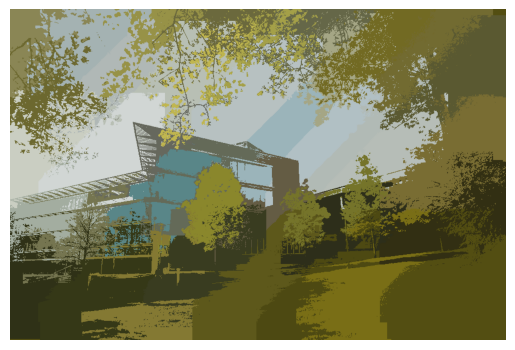

In [93]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(result_rgb.astype(np.uint8))
plt.axis("off")
plt.show()

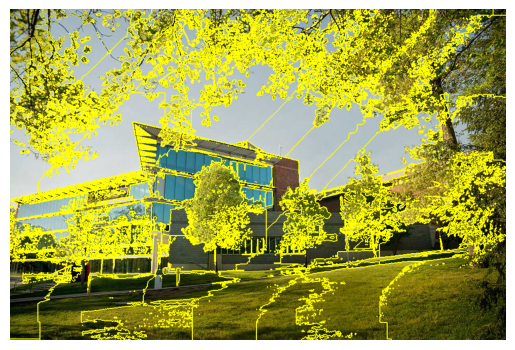

In [94]:
image = img_as_float(io.imread(image_path))
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mark_boundaries(image, segments.astype(np.uint8)))
plt.axis("off")
plt.savefig('myslic.pdf')
plt.show()

# Using skimage to implement SLIC

In [95]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
import matplotlib.pyplot as plt

In [96]:
image = img_as_float(io.imread(image_path))
segments = slic(image, n_segments = 50, sigma = 5)

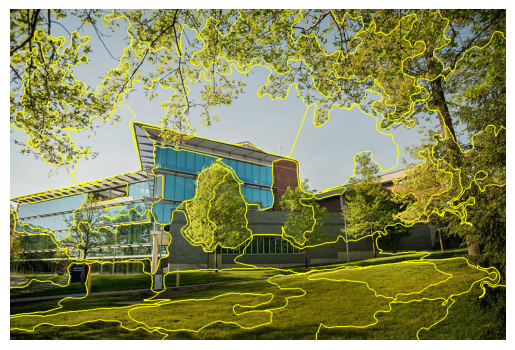

In [97]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mark_boundaries(image, segments.astype(np.uint8)))
plt.axis("off")
plt.savefig('skimageslic.pdf')
plt.show()